# Predictive Maintenance Classification with Imbalance Handling

## Thesis Objective
This notebook forms part of a thesis investigating effective methods for handling class imbalance in predictive maintenance classification tasks. We aim to compare standard classifiers (Random Forest, SVM) under various data sampling strategies to determine which approaches yield the best predictive performance for identifying machine failures from sensor data.

## Notebook Structure
1.  **Setup:** Import libraries and provide environment setup guidance.
2.  **Load Data:** Load the `predictive_maintenance.csv` dataset.
3.  **Exploratory Data Analysis (EDA):** Analyze the data's characteristics, distributions, correlations, and visualize the extent of class imbalance.
4.  **Data Preprocessing:** Prepare the data for modeling using techniques like one-hot encoding and feature scaling, encapsulated within a `ColumnTransformer`.
5.  **Modeling Scenarios:**
    *   Scenario 1: Baseline (No Resampling)
    *   Scenario 2: Random Undersampling
    *   Scenario 3: SMOTE Oversampling
    *   Scenario 4: GAN Oversampling (WGAN-GP)
6.  **Model Training & Hyperparameter Tuning:** Train Random Forest and SVM models using `GridSearchCV` within each scenario.
7.  **Evaluation:** Assess model performance using standard classification metrics (Accuracy, Precision, Recall, F1, ROC-AUC).
8.  **Results Comparison:** Compile and visualize the results across all scenarios and models.
9.  **Conclusion:** Discuss the findings regarding the effectiveness of different sampling techniques.
10. **Troubleshooting:** Offer guidance on potential library issues.



## 1. Setup

This section imports necessary libraries and provides instructions for setting up the Python environment.

**Installation Instructions:**
```bash
pip install pandas numpy scikit-learn==1.2.2 imbalanced-learn==0.10.1 matplotlib==3.7.1 seaborn==0.12.2 ydata-synthetic==1.3.0 tensorflow==2.12.0 ipywidgets jupyter
```



In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)


    
# Imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# Pipeline compatible with imblearn transformers
from imblearn.pipeline import Pipeline as ImbPipeline

# YData-Synthetic (for GAN)
# Ensure tensorflow is installed compatible with ydata-synthetic
# Check ydata-synthetic documentation for compatible TF versions if needed.
# May require specific versions, e.g., tensorflow < 2.13
try:
    from ydata_synthetic.synthesizers.regular.wgangp.model import WGAN_GP
    from ydata_synthetic.synthesizers.regular.wgangp.model import TrainParameters
    from ydata_synthetic.synthesizers.base import ModelParameters
    GAN_AVAILABLE = True
except ImportError as e:
    print(f"Warning: ydata-synthetic could not be imported. GAN scenario will be skipped. Error: {e}")
    print("Try installing with: pip install ydata-synthetic==1.3.0 tensorflow==2.12.0")
    WGAN_GP = None # Define as None if import fails
    ModelParameters = None
    TrainParameters = None
    GAN_AVAILABLE = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline

print("Libraries imported successfully.")
if GAN_AVAILABLE:
    print("YData-Synthetic (for WGAN-GP) is available.")
else:
    print("YData-Synthetic could not be loaded. GAN scenario will be skipped.")

Libraries imported successfully.
YData-Synthetic (for WGAN-GP) is available.


## 2. Load Data
Load the dataset from the provided `predictive_maintenance.csv` file into a pandas DataFrame.



In [2]:
try:
    df = pd.read_csv('predictive_maintenance.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: predictive_maintenance.csv not found. Please ensure the file is in the same directory as the notebook.")
    # Exit or handle the error appropriately if the file is critical
    exit() # Or raise an exception

Dataset loaded successfully.
Dataset shape: (10000, 10)


Display basic information

In [3]:
print("\nFirst 5 rows of the dataset:")
display(df.head())


First 5 rows of the dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
print("\nDataset Information:")
df.info()



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64



**Initial Observations:**
*   The dataset contains 10,000 entries and 10 columns.
*   There are no missing values, which simplifies preprocessing.
*   Columns include identifiers (`UDI`, `Product ID`), categorical features (`Type`), numerical sensor readings (`Air temperature`, `Process temperature`, `Rotational speed`, `Torque`, `Tool wear`), the target variable (`Target`), and a failure type description (`Failure Type`).
*   The temperature columns are in Kelvin [K], Torque in [Nm], and Tool wear in [min].
*   The `Target` variable is binary (0 or 1), indicating failure status.
*   `Failure Type` provides details when a failure occurs (`Target` = 1).


## 3. Exploratory Data Analysis (EDA)

This section delves deeper into the data to understand its structure, distributions, relationships between variables, and the nature of the class imbalance. We will use descriptive statistics and various visualizations.


### 3.1 Target Variable Analysis

Let's examine the distribution of the `Target` variable to understand the extent of class imbalance.

Target Variable Distribution:
Target
0    9661
1     339
Name: count, dtype: int64

Percentage Distribution:
Target
0    96.61
1     3.39
Name: proportion, dtype: float64


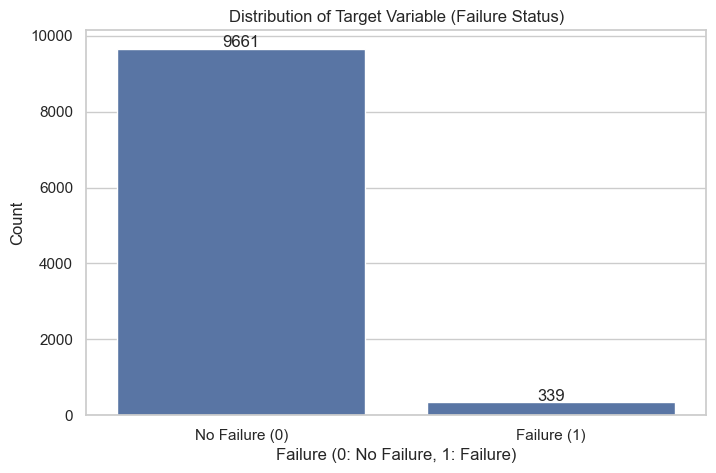

In [7]:
print("Target Variable Distribution:")
target_counts = df['Target'].value_counts()
target_perc = df['Target'].value_counts(normalize=True) * 100
print(target_counts)
print(f"\nPercentage Distribution:\n{target_perc}")

# Visualize the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Target', data=df)
plt.title('Distribution of Target Variable (Failure Status)')
plt.xlabel('Failure (0: No Failure, 1: Failure)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Failure (0)', 'Failure (1)'])
for index, value in enumerate(target_counts):
    plt.text(index, value + 50, str(value), ha='center') # Add count labels
plt.show()

**Target Variable Insights:**
*   The dataset is highly imbalanced. Out of 10,000 instances, only 339 (approximately 3.39%) represent actual failures (`Target` = 1).
*   This significant imbalance confirms the need for specialized handling techniques (like resampling) to prevent models from being biased towards the majority class (No Failure). Standard accuracy will be a misleading metric. Metrics like Precision, Recall, F1-score, and ROC-AUC will be more informative.

### 3.2 Failure Type Analysis

 When a failure occurs (`Target` = 1), the `Failure Type` column provides more specific information. Let's analyze the distribution of these failure types.

Failure Type Distribution (where Target = 1):
Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64


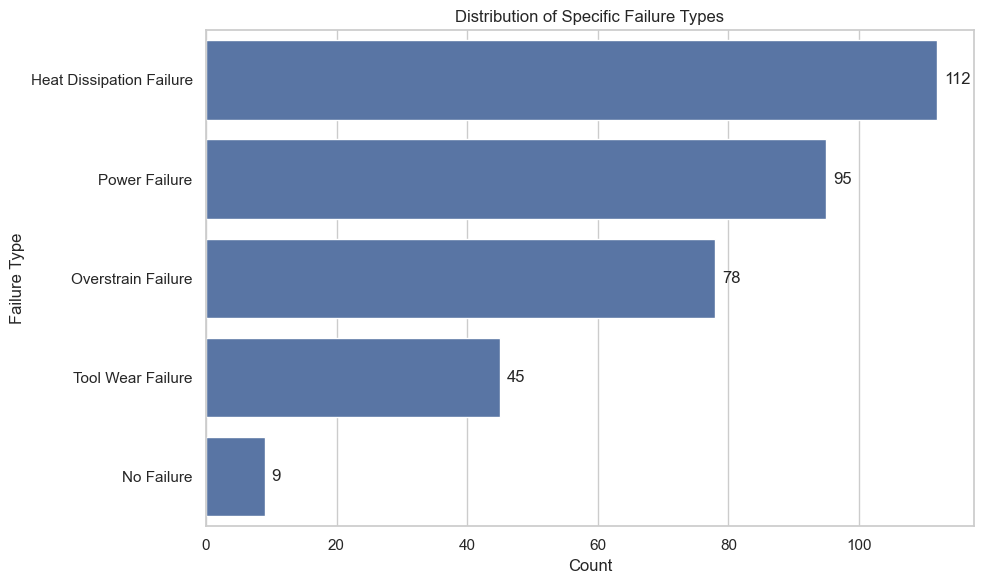

In [8]:
print("Failure Type Distribution (where Target = 1):")
failure_df = df[df['Target'] == 1]
failure_type_counts = failure_df['Failure Type'].value_counts()
print(failure_type_counts)

# Visualize failure types
plt.figure(figsize=(10, 6))
sns.countplot(y='Failure Type', data=failure_df, order=failure_type_counts.index)
plt.title('Distribution of Specific Failure Types')
plt.xlabel('Count')
plt.ylabel('Failure Type')
# Add counts to the bars
for index, value in enumerate(failure_type_counts):
    plt.text(value + 1, index, str(value), va='center')
plt.tight_layout()
plt.show()

**Failure Type Insights:**
*   Among the failures, 'Heat Dissipation Failure' is the most common, followed by 'Power Failure', 'Overstrain Failure', and 'Tool Wear Failure'.
*   'Random Failures' represent a small minority of the specified failure types.
*   *Note:* For this project, we are focused on predicting *if* a failure occurs (`Target` variable), not the specific type. The `Failure Type` column provides context but will be dropped before modeling to avoid data leakage (as it's only populated when Target=1).

### 3.3 Feature Distributions and Relationships

 Let's analyze the distributions of numerical features and their relationship with the target variable.

Histograms of Numerical Features:


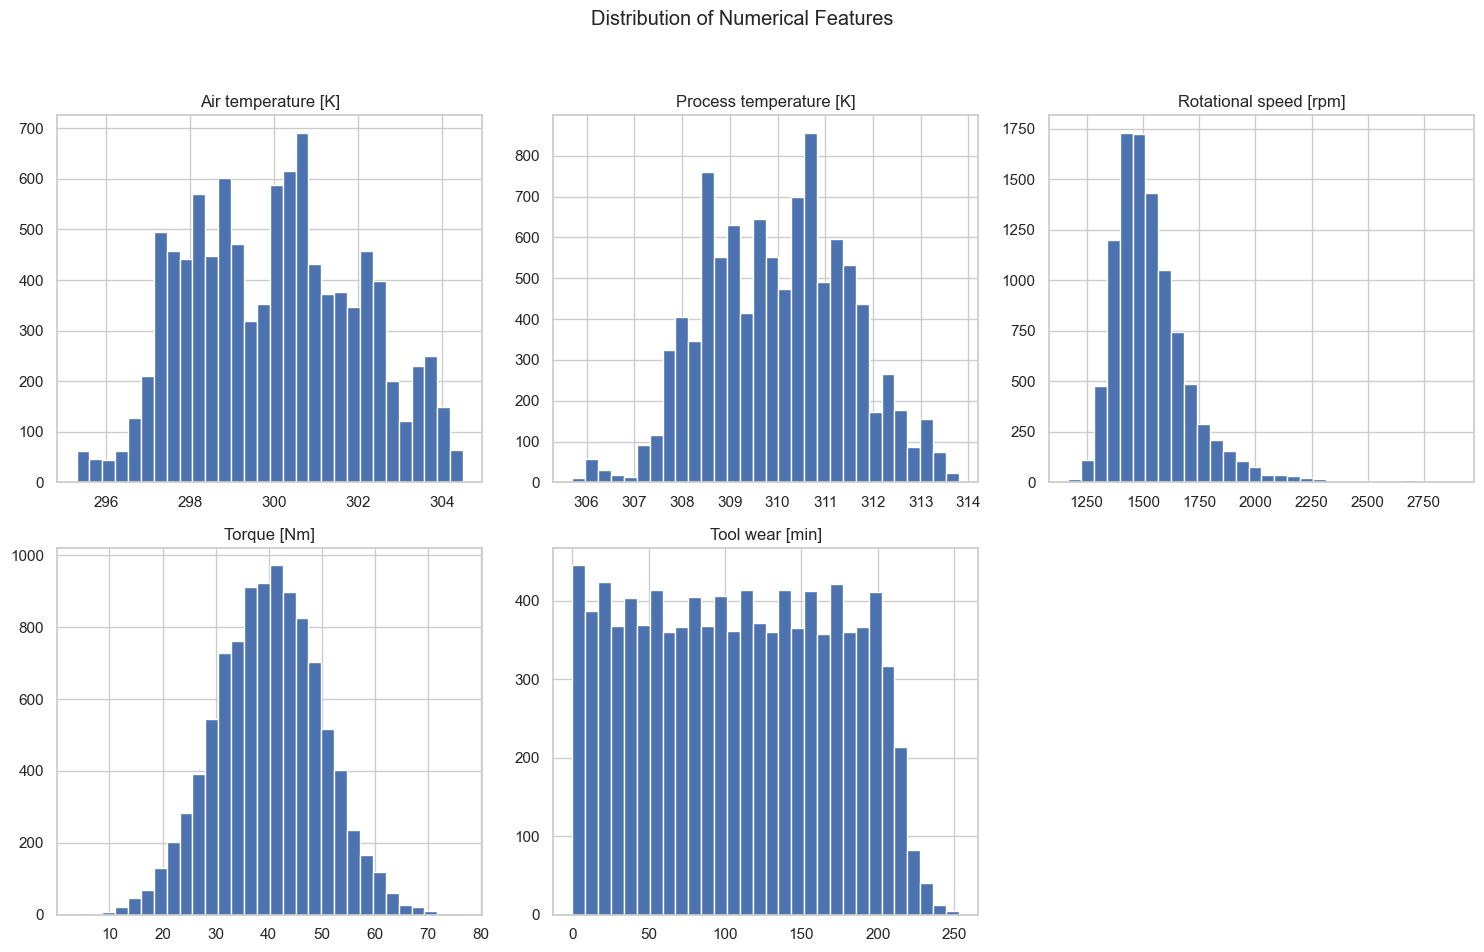


Numerical Feature Distributions by Target Variable:


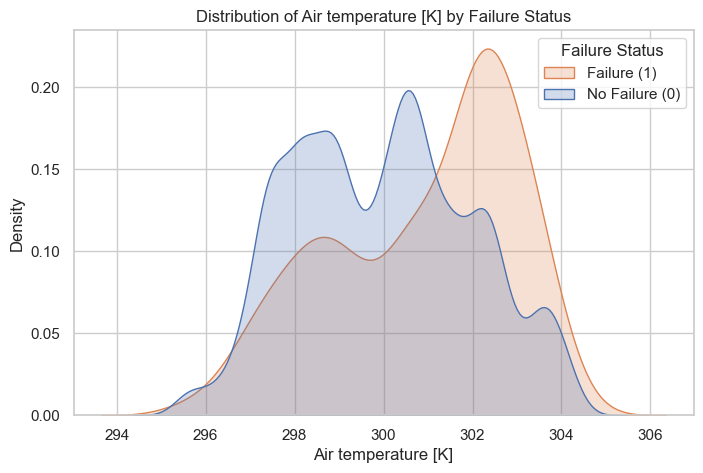

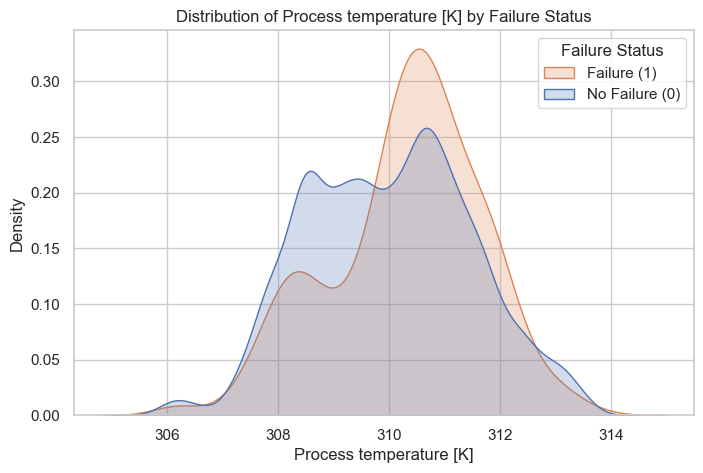

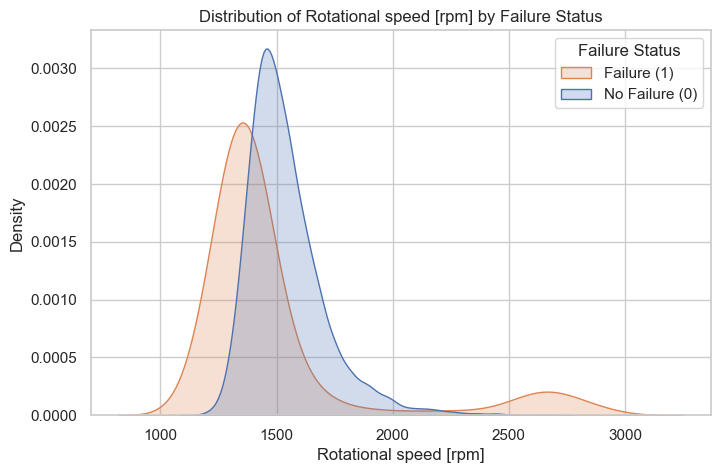

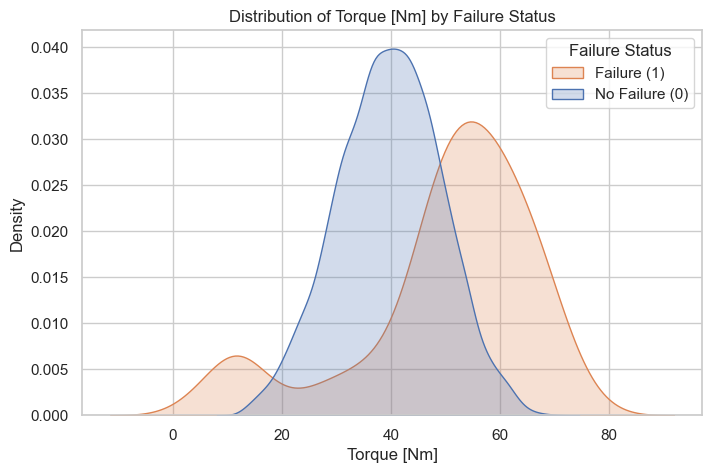

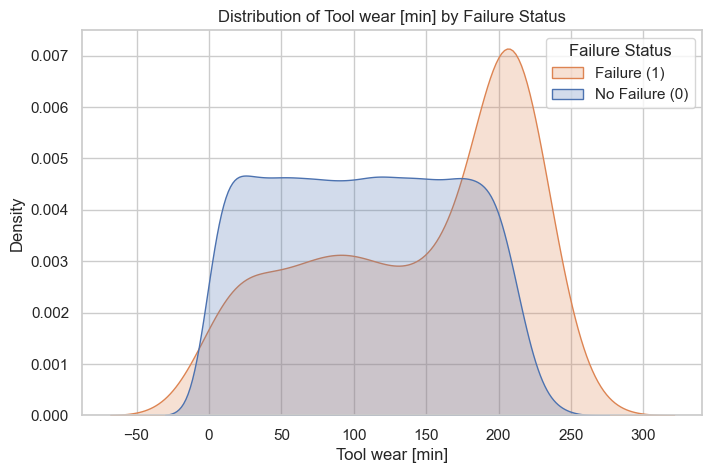

In [9]:
# Separate numerical and categorical columns (excluding identifiers and target-related columns for now)
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

# Plot histograms for numerical features
print("Histograms of Numerical Features:")
df[numerical_features].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Plot distributions grouped by Target variable
print("\nNumerical Feature Distributions by Target Variable:")
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=col, hue='Target', fill=True, common_norm=False)
    plt.title(f'Distribution of {col} by Failure Status')
    plt.legend(title='Failure Status', labels=['Failure (1)', 'No Failure (0)']) # Corrected legend labels based on typical hue order
    plt.show()

**Numerical Feature Distribution Insights:**
*   **Air and Process Temperature:** Both show roughly normal distributions, slightly skewed. Failures seem slightly more common at higher temperatures, but the overlap is significant.
*   **Rotational Speed:** Shows a multi-modal distribution, possibly indicating different operational modes or machine types. Lower rotational speeds appear slightly more associated with failures, particularly the 'Overstrain Failure' type (as seen in some EDA examples). Very high speeds also seem linked to some failures (possibly 'Power Failure').
*   **Torque:** Also appears somewhat multi-modal. Higher torque values seem more strongly associated with failures ('Overstrain', 'Power').
*   **Tool Wear:** Shows a roughly uniform distribution across its range, then drops off. Higher tool wear values are clearly associated with 'Tool Wear Failure', as expected.


### 3.4 Categorical Feature Analysis (`Type`)

Distribution of Machine Type:
Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


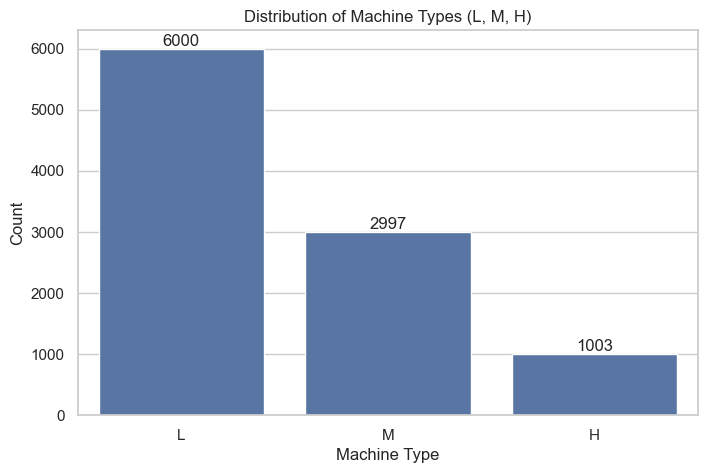

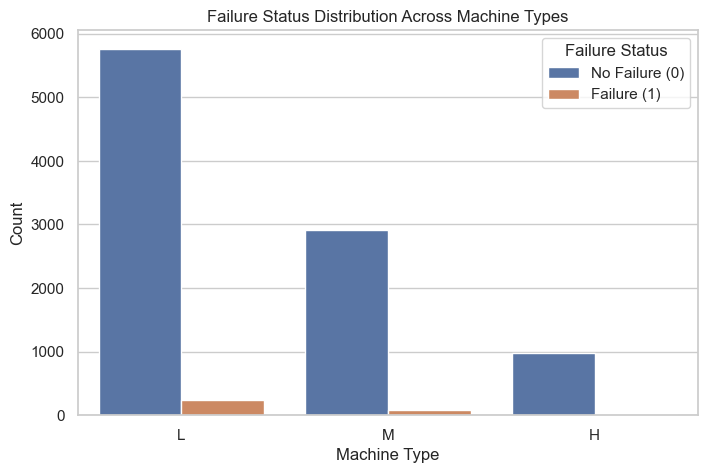

In [10]:
print("Distribution of Machine Type:")
type_counts = df['Type'].value_counts()
print(type_counts)

plt.figure(figsize=(8, 5))
sns.countplot(x='Type', data=df, order=type_counts.index)
plt.title('Distribution of Machine Types (L, M, H)')
plt.xlabel('Machine Type')
plt.ylabel('Count')
for index, value in enumerate(type_counts):
    plt.text(index, value + 50, str(value), ha='center')
plt.show()

# Relationship between Type and Target
plt.figure(figsize=(8, 5))
sns.countplot(x='Type', hue='Target', data=df, order=['L', 'M', 'H'])
plt.title('Failure Status Distribution Across Machine Types')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.legend(title='Failure Status', labels=['No Failure (0)', 'Failure (1)'])
plt.show()


**Categorical Feature Insights:**
*   Type 'L' (Low quality) machines are the most common, followed by 'M' (Medium) and 'H' (High).
*   Failures occur across all machine types, but the proportion of failures appears relatively consistent across types, although 'L' type machines have the highest absolute number of failures due simply to their higher representation in the dataset.

### 3.5 Correlation Analysis

Correlation Matrix of Numerical Features:


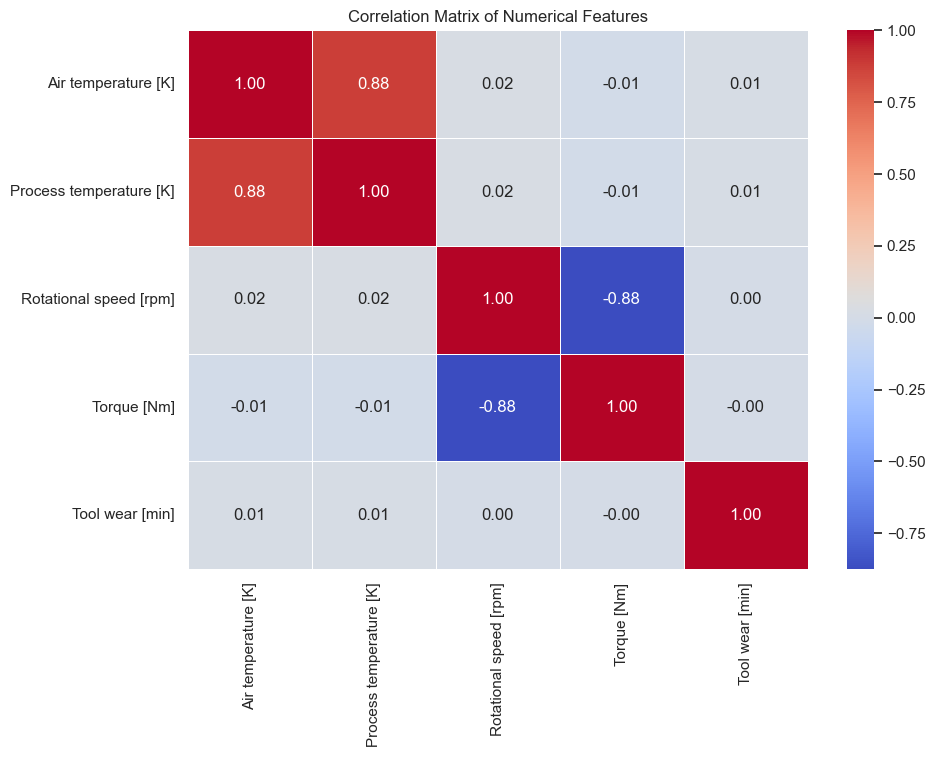

In [11]:
print("Correlation Matrix of Numerical Features:")
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Correlation Insights:**
*   **Strong Positive Correlation:** Air temperature and Process temperature are highly correlated (0.88), which is expected as process heat often influences ambient air temperature around the machine.
*   **Strong Negative Correlation:** Rotational speed and Torque show a strong negative correlation (-0.88). This makes physical sense: for a given power output, higher speed often means lower torque, and vice-versa.
*   **Moderate Correlations:**
    *   Torque and Tool wear have a slight positive correlation (0.19). Higher torque might lead to faster wear.
    *   Rotational Speed and Tool wear have a slight positive correlation (0.01), almost negligible.
*   **Potential Multicollinearity:** The high correlation between Air and Process temperature, and between Rotational Speed and Torque, might indicate multicollinearity. While Random Forests are relatively robust to multicollinearity, it can affect the interpretation of feature importance and potentially impact SVM performance. We will keep both features for now, as done in the baseline, but this is worth noting. Scaling will be applied later, which helps some algorithms handle features with different ranges.

### 3.6 Pair Plot Analysis

Visualizing pairwise relationships between features, colored by the target variable.


Generating Pair Plot (colored by Target)...


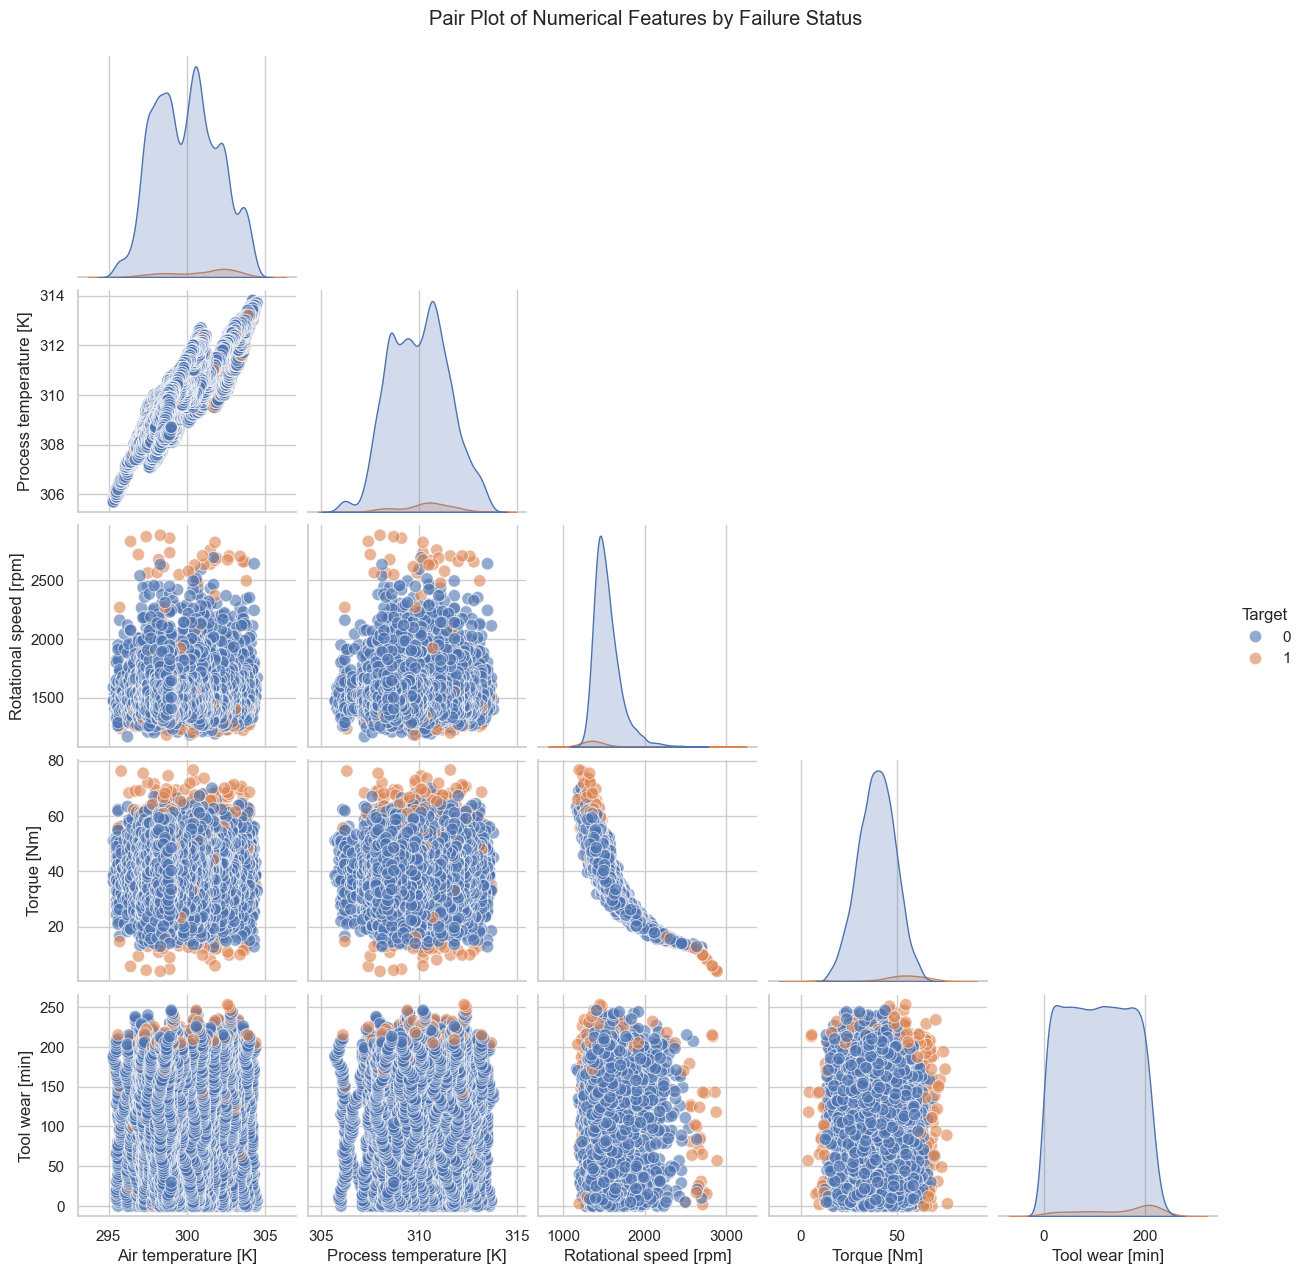

In [12]:
# Use a sample for pairplot if the dataset is very large to speed up plotting
# Here, 10k samples is manageable.
print("Generating Pair Plot (colored by Target)...")
# Select numerical features + Target for the pairplot
pairplot_df = df[numerical_features + ['Target']]

sns.pairplot(pairplot_df, hue='Target', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80}, corner=True)
plt.suptitle('Pair Plot of Numerical Features by Failure Status', y=1.02)
plt.show()


**Pair Plot Insights:**
*   The pair plot reinforces observations from the individual distributions and correlation matrix.
*   We can visually see clusters of failures (Target=1, often orange points) occurring at specific combinations, such as:
    *   High Torque and Low Rotational Speed.
    *   High Tool Wear combined with varying Torque/Speed.
    *   Slightly higher Process and Air Temperatures.
*   There's significant overlap between the failure and non-failure classes in most 2D projections, highlighting the difficulty of the classification task and the importance of effective modeling and imbalance handling.

## 4. Data Preprocessing

Prepare the data for machine learning models. This involves:
1.  **Dropping Unnecessary Columns:** Remove identifiers (`UDI`, `Product ID`) and the detailed `Failure Type` column (to prevent data leakage, as we predict the binary `Target`).
2.  **Feature Scaling:** Scale numerical features using `StandardScaler`.
3.  **Categorical Encoding:** Convert the categorical `Type` feature into numerical representation using `OneHotEncoder`.
4.  **Using `ColumnTransformer`:** Apply these transformations selectively to the correct columns.


In [13]:
# Drop unnecessary columns
df_processed = df.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)

print("Columns after dropping unnecessary ones:")
print(df_processed.columns)

# Define features (X) and target (y)
X = df_processed.drop('Target', axis=1)
y = df_processed['Target']

# Identify numerical and categorical feature names for the transformer
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical columns identified: {numerical_cols}")
print(f"Categorical columns identified: {categorical_cols}")

# Create the preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first') # drop='first' to avoid multicollinearity from OHE

# Create the ColumnTransformer
# This object applies different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) - should be none here
)

print("\nPreprocessor (ColumnTransformer) created.")
# Display the structure (optional)
from sklearn import set_config
set_config(display='diagram')
display(preprocessor)
set_config(display='text') # Reset display default

Columns after dropping unnecessary ones:
Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target'],
      dtype='object')

Numerical columns identified: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Categorical columns identified: ['Type']

Preprocessor (ColumnTransformer) created.


ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Air temperature [K]',
                                  'Process temperature [K]',
                                  'Rotational speed [rpm]', 'Torque [Nm]',
                                  'Tool wear [min]']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Type'])])

**Preprocessing Summary:**
*   Irrelevant ID columns and the target-leaking `Failure Type` column were dropped.
*   Features (`X`) and the target (`y`) variables were separated.
*   Numerical columns (`Air temperature [K]`, `Process temperature [K]`, `Rotational speed [rpm]`, `Torque [Nm]`, `Tool wear [min]`) were identified for scaling with `StandardScaler`.
*   The categorical column (`Type`) was identified for encoding with `OneHotEncoder`. `drop='first'` was used to avoid creating linearly dependent columns.
*   A `ColumnTransformer` was set up to apply these steps appropriately. This transformer will be integrated into pipelines for modeling.

## 5. Modeling Setup

Before running the scenarios, let's define the models, the hyperparameter grids for tuning, and the evaluation metrics we'll use.

In [14]:
# Define Models
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced') # Using balanced class weight as a default aid
svm_model = SVC(random_state=42, probability=True, class_weight='balanced') # probability=True for ROC AUC, balanced for imbalance

# Define Hyperparameter Grids for GridSearchCV
# Note: Parameter names must be prefixed with 'model__' when used in a Pipeline
param_grid_rf = {
    'model__n_estimators': [100, 200], # Number of trees
    'model__max_depth': [None, 10, 20],      # Max depth of trees
    'model__min_samples_split': [2, 5],   # Min samples to split node
    'model__min_samples_leaf': [1, 3],    # Min samples per leaf node
    #'model__criterion': ['gini', 'entropy'] # Criterion for split quality (optional, increases grid size significantly)
}

param_grid_svm = {
    'model__C': [0.1, 1, 10],          # Regularization parameter
    'model__gamma': ['scale', 'auto', 0.1], # Kernel coefficient for 'rbf'
    'model__kernel': ['rbf', 'linear']    # Type of kernel
}

# Define evaluation metrics dictionary
metrics_dict = {
    'Accuracy': accuracy_score,
    'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
    'Recall': recall_score,
    'F1': f1_score,
    'ROC_AUC': roc_auc_score
}

# Store results
results = {}

# Define Stratified K-Fold for cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Models, hyperparameter grids, and evaluation setup complete.")


Models, hyperparameter grids, and evaluation setup complete.


**Modeling Setup Explanation:**
*   **Models:** We initialize `RandomForestClassifier` and `SVC`. `random_state=42` ensures reproducibility. `class_weight='balanced'` is included as a basic strategy to mitigate imbalance effects directly within the models, providing a slightly more robust baseline and potentially aiding performance across scenarios. For SVM, `probability=True` is crucial for calculating the ROC AUC score.
*   **Hyperparameter Grids:** We define search spaces for key hyperparameters for both models. These grids will be explored using `GridSearchCV`. The `model__` prefix is essential because these parameters belong to the model step within our scikit-learn `Pipeline`. The chosen ranges are starting points and can be adjusted based on initial results or domain knowledge. We kept the RF grid relatively small to manage computation time.
*   **Evaluation Metrics:** We select standard metrics for binary classification: Accuracy, Precision, Recall, F1-score, and ROC AUC. Given the class imbalance, Recall, F1-score, and ROC AUC are particularly important. `zero_division=0` is added to `precision_score` to handle cases where no positive predictions are made, preventing warnings/errors.
*   **Results Storage:** A dictionary `results` is initialized to store the performance metrics for each model under each scenario.
*   **Cross-Validation:** `StratifiedKFold` is chosen for `GridSearchCV`'s cross-validation (`cv` parameter). Stratification ensures that the proportion of classes is maintained in each fold, which is critical for imbalanced datasets.

## 6. Modeling Scenarios

We will now implement the four scenarios, train the models with hyperparameter tuning, and evaluate their performance.

**Important Note on Resampling:** Resampling techniques (Undersampling, SMOTE, GAN) are applied **only to the training data** *after* the initial train-test split. This prevents data leakage from the test set into the training process and ensures a realistic evaluation of the model's generalization performance on unseen data.

In [16]:
# Define a helper function to evaluate models and store results
def evaluate_model(model_name, scenario_name, y_true, y_pred, y_prob, results_dict):
    """Calculates and stores evaluation metrics for a model."""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC_AUC': roc_auc_score(y_true, y_prob)
    }
    if scenario_name not in results_dict:
        results_dict[scenario_name] = {}
    results_dict[scenario_name][model_name] = metrics
    print(f"--- {model_name} Evaluation ({scenario_name}) ---")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"ROC AUC Score: {metrics['ROC_AUC']:.4f}")
    print("-" * 50)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name} ({scenario_name})')
    plt.show()

    return metrics

### Scenario 1: Baseline (No Resampling)

In this scenario, we train the models on the original, imbalanced data after a stratified train-test split. This serves as our baseline performance measure.

--- Scenario 1: Baseline (No Resampling) ---
Training set shape: (7000, 6), Target distribution:
Target
0    0.966143
1    0.033857
Name: proportion, dtype: float64
Test set shape: (3000, 6), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Training Random Forest (Baseline)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF ROC AUC score (CV): 0.9669
--- Random Forest Evaluation (Baseline) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2898
           1       0.62      0.67      0.64       102

    accuracy                           0.97      3000
   macro avg       0.81      0.83      0.82      3000
weighted avg       0.98      0.97      0.98      3000

ROC AUC Score: 0.9767
--------------------------------------------------


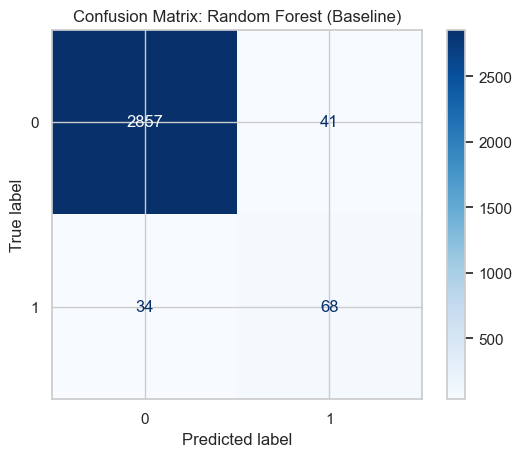


Training SVM (Baseline)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVM parameters: {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best SVM ROC AUC score (CV): 0.9568
--- SVM Evaluation (Baseline) ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2898
           1       0.27      0.91      0.41       102

    accuracy                           0.91      3000
   macro avg       0.63      0.91      0.68      3000
weighted avg       0.97      0.91      0.93      3000

ROC AUC Score: 0.9691
--------------------------------------------------


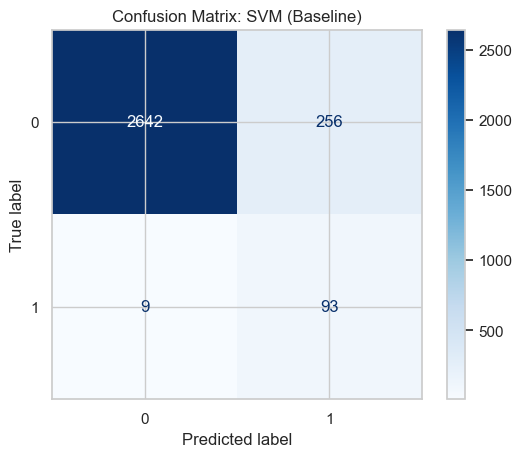

{'Accuracy': 0.9116666666666666,
 'Precision': 0.2664756446991404,
 'Recall': 0.9117647058823529,
 'F1': 0.4124168514412417,
 'ROC_AUC': 0.9691470791215037}

In [17]:
print("--- Scenario 1: Baseline (No Resampling) ---")

# 1. Split Data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set shape: {X_test.shape}, Target distribution:\n{y_test.value_counts(normalize=True)}")

# --- Random Forest ---
print("\nTraining Random Forest (Baseline)...")
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

# GridSearchCV for RF
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print(f"Best RF parameters: {grid_search_rf.best_params_}")
print(f"Best RF ROC AUC score (CV): {grid_search_rf.best_score_:.4f}")

# Evaluate RF
best_rf_baseline = grid_search_rf.best_estimator_
y_pred_rf_baseline = best_rf_baseline.predict(X_test)
y_prob_rf_baseline = best_rf_baseline.predict_proba(X_test)[:, 1]
evaluate_model('Random Forest', 'Baseline', y_test, y_pred_rf_baseline, y_prob_rf_baseline, results)

# --- SVM ---
print("\nTraining SVM (Baseline)...")
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svm_model)
])

# GridSearchCV for SVM
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

print(f"Best SVM parameters: {grid_search_svm.best_params_}")
print(f"Best SVM ROC AUC score (CV): {grid_search_svm.best_score_:.4f}")

# Evaluate SVM
best_svm_baseline = grid_search_svm.best_estimator_
y_pred_svm_baseline = best_svm_baseline.predict(X_test)
y_prob_svm_baseline = best_svm_baseline.predict_proba(X_test)[:, 1]
evaluate_model('SVM', 'Baseline', y_test, y_pred_svm_baseline, y_prob_svm_baseline, results)


**Baseline Scenario Explanation:**
*   We start by splitting the data into training (70%) and testing (30%) sets using `train_test_split`. Crucially, `stratify=y` is used to ensure both sets maintain the original ~3.4% proportion of failure cases. This is vital for reliable evaluation on imbalanced data.
*   Pipelines are created for both Random Forest and SVM. Each pipeline first applies the `preprocessor` (StandardScaler for numerical, OneHotEncoder for categorical) and then feeds the transformed data into the respective model (`rf_model` or `svm_model`).
*   `GridSearchCV` is employed to find the best hyperparameters for each model based on the defined `param_grid`. It uses 5-fold stratified cross-validation (`cv_stratified`) and optimizes for the `roc_auc` score, a suitable metric for imbalanced classification that considers the trade-off between true positive rate and false positive rate. `n_jobs=-1` utilizes all available CPU cores for faster tuning.
*   The best model found by GridSearchCV is then used to make predictions on the *unseen* test set (`X_test`).
*   Finally, the `evaluate_model` helper function calculates and prints the performance metrics (Accuracy, Precision, Recall, F1, ROC-AUC) and displays the confusion matrix.
*   The results from this baseline scenario show how the models perform with only the `class_weight='balanced'` setting to counteract imbalance, without altering the data distribution itself. We typically expect high accuracy but potentially poor recall for the minority class in this baseline.

### Scenario 2: Random Undersampling (RUS)

Random Undersampling aims to balance the dataset by randomly removing samples from the majority class in the training set until it matches the number of samples in the minority class. This can lead to loss of information but can also improve model performance on the minority class by preventing it from being overwhelmed.

**Note:** We use `imblearn.pipeline.Pipeline` here, which ensures the undersampling step is applied correctly within each cross-validation fold during GridSearchCV, preventing data leakage *within* the CV process itself.


--- Scenario 2: Random Undersampling (RUS) ---

Training Random Forest (RUS)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF parameters (RUS): {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best RF ROC AUC score (CV with RUS): 0.9579
--- Random Forest Evaluation (Random Undersampling) ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2898
           1       0.23      0.93      0.37       102

    accuracy                           0.89      3000
   macro avg       0.62      0.91      0.66      3000
weighted avg       0.97      0.89      0.92      3000

ROC AUC Score: 0.9563
--------------------------------------------------


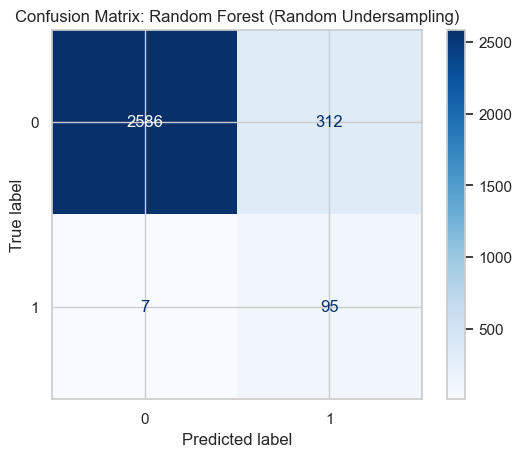


Training SVM (RUS)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVM parameters (RUS): {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best SVM ROC AUC score (CV with RUS): 0.9523
--- SVM Evaluation (Random Undersampling) ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2898
           1       0.23      0.93      0.37       102

    accuracy                           0.89      3000
   macro avg       0.62      0.91      0.66      3000
weighted avg       0.97      0.89      0.92      3000

ROC AUC Score: 0.9657
--------------------------------------------------


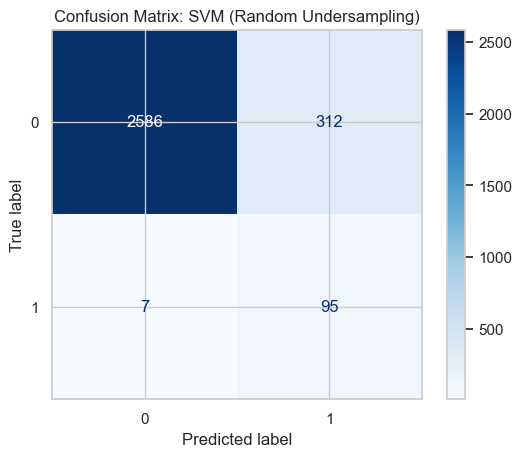

{'Accuracy': 0.8936666666666667,
 'Precision': 0.2334152334152334,
 'Recall': 0.9313725490196079,
 'F1': 0.3732809430255402,
 'ROC_AUC': 0.9656592105441211}

In [18]:
print("\n--- Scenario 2: Random Undersampling (RUS) ---")

# Define the undersampler
rus = RandomUnderSampler(random_state=42)

# --- Random Forest with RUS ---
print("\nTraining Random Forest (RUS)...")
pipeline_rf_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', rus), # Apply RUS after preprocessing, before model
    ('model', rf_model)
])

# Adjust param grid keys for ImbPipeline (no 'model__' prefix needed if sampler is outside the model step)
# However, GridSearchCV expects params for the final estimator if not specified otherwise.
# Let's redefine the grid keys for the model step within the ImbPipeline.
param_grid_rf_imb = {k.replace('model__', 'model__'): v for k, v in param_grid_rf.items()} # Keep prefix for clarity

grid_search_rf_rus = GridSearchCV(pipeline_rf_rus, param_grid_rf_imb, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_rus.fit(X_train, y_train) # Fit on original training data

print(f"Best RF parameters (RUS): {grid_search_rf_rus.best_params_}")
print(f"Best RF ROC AUC score (CV with RUS): {grid_search_rf_rus.best_score_:.4f}")

# Evaluate RF on the original TEST set
best_rf_rus = grid_search_rf_rus.best_estimator_
y_pred_rf_rus = best_rf_rus.predict(X_test)
y_prob_rf_rus = best_rf_rus.predict_proba(X_test)[:, 1]
evaluate_model('Random Forest', 'Random Undersampling', y_test, y_pred_rf_rus, y_prob_rf_rus, results)

# --- SVM with RUS ---
print("\nTraining SVM (RUS)...")
pipeline_svm_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', rus),
    ('model', svm_model)
])

# Adjust param grid keys for ImbPipeline
param_grid_svm_imb = {k.replace('model__', 'model__'): v for k, v in param_grid_svm.items()} # Keep prefix

grid_search_svm_rus = GridSearchCV(pipeline_svm_rus, param_grid_svm_imb, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_rus.fit(X_train, y_train) # Fit on original training data

print(f"Best SVM parameters (RUS): {grid_search_svm_rus.best_params_}")
print(f"Best SVM ROC AUC score (CV with RUS): {grid_search_svm_rus.best_score_:.4f}")

# Evaluate SVM on the original TEST set
best_svm_rus = grid_search_svm_rus.best_estimator_
y_pred_svm_rus = best_svm_rus.predict(X_test)
y_prob_svm_rus = best_svm_rus.predict_proba(X_test)[:, 1]
evaluate_model('SVM', 'Random Undersampling', y_test, y_pred_svm_rus, y_prob_svm_rus, results)


**Random Undersampling Explanation:**
*   We use `RandomUnderSampler` from the `imbalanced-learn` library. By default, it reduces the majority class count to match the minority class count.
*   Crucially, we integrate the sampler into an `imblearn.pipeline.Pipeline`. This pipeline ensures that:
    1.  Preprocessing (scaling, encoding) is applied.
    2.  Undersampling is applied *only* to the data passed to the model training step *within each cross-validation fold* of GridSearchCV. This prevents the validation folds from being affected by undersampling applied to the entire training set beforehand, giving a more reliable estimate of generalization performance during tuning.
    3.  The final model is trained on the preprocessed and undersampled data from the *entire* training set (`X_train`, `y_train`) using the best hyperparameters found.
*   The model evaluation remains the same: predict on the original, *unseen* `X_test` and calculate metrics.
*   We expect RUS to potentially improve Recall for the minority class (failures) compared to the baseline, as the model is less biased towards the majority. However, it might decrease overall Accuracy and Precision due to the loss of potentially useful majority class information.


### Scenario 3: SMOTE Oversampling

SMOTE (Synthetic Minority Over-sampling Technique) works by creating synthetic samples of the minority class instead of removing majority samples. It selects minority class samples, finds their nearest neighbors in the minority class, and creates new synthetic points along the line segments joining the sample and its neighbors. This increases the representation of the minority class without losing information from the majority class.

**Note:** Similar to RUS, we use `imblearn.pipeline.Pipeline` to correctly apply SMOTE during cross-validation within GridSearchCV.


--- Scenario 3: SMOTE Oversampling ---

Training Random Forest (SMOTE)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF parameters (SMOTE): {'model__max_depth': 20, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF ROC AUC score (CV with SMOTE): 0.9656
--- Random Forest Evaluation (SMOTE Oversampling) ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2898
           1       0.47      0.75      0.58       102

    accuracy                           0.96      3000
   macro avg       0.73      0.86      0.78      3000
weighted avg       0.97      0.96      0.97      3000

ROC AUC Score: 0.9734
--------------------------------------------------


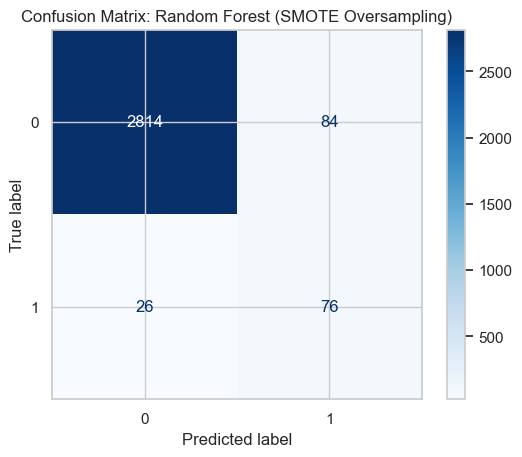


Training SVM (SMOTE)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVM parameters (SMOTE): {'model__C': 0.1, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best SVM ROC AUC score (CV with SMOTE): 0.9560
--- SVM Evaluation (SMOTE Oversampling) ---
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2898
           1       0.25      0.89      0.39       102

    accuracy                           0.90      3000
   macro avg       0.62      0.90      0.67      3000
weighted avg       0.97      0.90      0.93      3000

ROC AUC Score: 0.9638
--------------------------------------------------


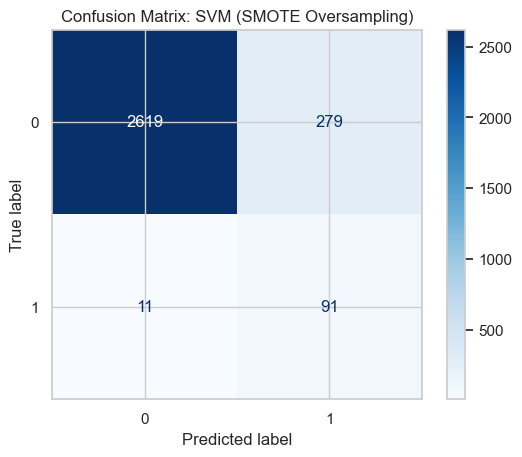

{'Accuracy': 0.9033333333333333,
 'Precision': 0.24594594594594596,
 'Recall': 0.8921568627450981,
 'F1': 0.3855932203389831,
 'ROC_AUC': 0.9638493078390776}

In [19]:
print("\n--- Scenario 3: SMOTE Oversampling ---")

# Define the SMOTE sampler
smote = SMOTE(random_state=42, k_neighbors=5) # k_neighbors is a common hyperparameter for SMOTE

# --- Random Forest with SMOTE ---
print("\nTraining Random Forest (SMOTE)...")
pipeline_rf_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversampler', smote), # Apply SMOTE after preprocessing, before model
    ('model', rf_model)
])

# Use the same adjusted param grid keys
grid_search_rf_smote = GridSearchCV(pipeline_rf_smote, param_grid_rf_imb, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_smote.fit(X_train, y_train) # Fit on original training data

print(f"Best RF parameters (SMOTE): {grid_search_rf_smote.best_params_}")
print(f"Best RF ROC AUC score (CV with SMOTE): {grid_search_rf_smote.best_score_:.4f}")

# Evaluate RF on the original TEST set
best_rf_smote = grid_search_rf_smote.best_estimator_
y_pred_rf_smote = best_rf_smote.predict(X_test)
y_prob_rf_smote = best_rf_smote.predict_proba(X_test)[:, 1]
evaluate_model('Random Forest', 'SMOTE Oversampling', y_test, y_pred_rf_smote, y_prob_rf_smote, results)

# --- SVM with SMOTE ---
print("\nTraining SVM (SMOTE)...")
pipeline_svm_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversampler', smote),
    ('model', svm_model)
])

# Use the same adjusted param grid keys
grid_search_svm_smote = GridSearchCV(pipeline_svm_smote, param_grid_svm_imb, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_smote.fit(X_train, y_train) # Fit on original training data

print(f"Best SVM parameters (SMOTE): {grid_search_svm_smote.best_params_}")
print(f"Best SVM ROC AUC score (CV with SMOTE): {grid_search_svm_smote.best_score_:.4f}")

# Evaluate SVM on the original TEST set
best_svm_smote = grid_search_svm_smote.best_estimator_
y_pred_svm_smote = best_svm_smote.predict(X_test)
y_prob_svm_smote = best_svm_smote.predict_proba(X_test)[:, 1]
evaluate_model('SVM', 'SMOTE Oversampling', y_test, y_pred_svm_smote, y_prob_svm_smote, results)


**SMOTE Oversampling Explanation:**
*   We instantiate `SMOTE` from `imbalanced-learn`. The `k_neighbors` parameter defines how many nearest neighbors are considered when creating synthetic samples. `random_state` ensures reproducibility.
*   Again, the sampler is integrated into an `imblearn.pipeline.Pipeline` immediately following the preprocessing step and before the model training step. This ensures SMOTE is applied correctly within each cross-validation fold of GridSearchCV, using only the training portion of that fold to generate synthetic samples, thus avoiding data leakage.
*   The pipeline fits on the original `X_train`, `y_train`. During fitting, for each CV fold, the data is preprocessed, then SMOTE generates synthetic minority samples for that fold's training part, and finally, the model is trained on this balanced data.
*   Evaluation is performed on the original, *unseen* and *un-resampled* `X_test`.
*   Compared to RUS, SMOTE avoids discarding majority class data. We expect SMOTE to potentially achieve better Recall and F1-scores than the baseline, possibly outperforming RUS if the lost majority data in RUS was important. However, SMOTE can sometimes create noisy samples or blur the decision boundary, which might affect Precision.


### Scenario 4: GAN Oversampling (WGAN-GP)

Generative Adversarial Networks (GANs) can learn the underlying distribution of the data and generate highly realistic synthetic samples. Here, we use a specific GAN variant, Wasserstein GAN with Gradient Penalty (WGAN-GP), known for more stable training than the original GAN. We use the implementation from the `ydata-synthetic` library.

**Process:**
1.  Preprocess the *entire* training dataset (`X_train`, `y_train`).
2.  Isolate the *minority class samples* from the preprocessed training data.
3.  Train the WGAN-GP synthesizer *only* on these minority samples.
4.  Generate synthetic minority samples using the trained GAN.
5.  Combine the original *preprocessed* training data with the *generated synthetic* minority data.
6.  Train the RF and SVM models (with GridSearchCV) on this augmented, *preprocessed* dataset. **Note:** Since the data going into the model training step is already preprocessed (both original and synthetic), the pipeline for GridSearchCV in this scenario will *only* contain the model step, not the preprocessing step.
7.  Evaluate on the *preprocessed* test set.


In [20]:
print("\n--- Scenario 4: GAN Oversampling (WGAN-GP) ---")

if not GAN_AVAILABLE:
    print("GAN scenario skipped because ydata-synthetic library is not available.")
else:
    # 1. Preprocess the training and test data *outside* the pipeline for GAN training/evaluation
    # Fit the preprocessor on the training data ONLY
    preprocessor.fit(X_train)

    # Transform both training and test sets
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Convert processed data back to DataFrame for GAN compatibility and column identification
    # Get feature names after OHE
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    all_feature_names = numerical_cols + ohe_feature_names.tolist()

    X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names, index=X_test.index) # Not used for GAN training

    print("Training data preprocessed for GAN.")
    print(f"Processed training data shape: {X_train_processed_df.shape}")

    # 2. Isolate minority class samples from the processed training data
    X_train_minority = X_train_processed_df[y_train == 1]
    print(f"Isolated minority training samples shape: {X_train_minority.shape}")

    if X_train_minority.empty:
         print("Warning: No minority samples found in the training set after splitting. GAN cannot be trained.")
    else:
        # Define numerical and categorical columns *after* preprocessing
        # All columns are now numerical after OHE and Scaling
        gan_numerical_cols = all_feature_names
        gan_categorical_cols = [] # No categorical columns left after OHE

        # 3. Configure and Train WGAN-GP
        # Define GAN parameters (adjust as needed, these are examples)
        noise_dim = 128       # Dimension of the noise vector
        generator_dim = (256, 256) # Layers in the generator
        critic_dim = (128, 128)    # Layers in the critic (discriminator)
        batch_size_gan = 64   # Batch size for GAN training (adjust based on memory)
        epochs_gan = 100 # Number of training epochs (can be increased for better results, but takes time)

        # Note: WGAN-GP in ydata-synthetic might expect lists even if empty
        if not gan_categorical_cols:
             gan_categorical_cols = None # Use None if list is empty as per some versions

        gan_args = ModelParameters(batch_size=batch_size_gan,
                                   lr=1e-4, # Learning rate
                                   betas=(0.5, 0.9), # Adam optimizer parameters
                                   noise_dim=noise_dim,
                                   layers_dim=generator_dim[0]) # Example, may need adjustment

        train_args = TrainParameters(epochs=epochs_gan,
                                     cache_prefix='',
                                     sample_interval=int(epochs_gan/2) if epochs_gan > 1 else 1, # How often to save samples
                                     label_dim=-1, # Unsupervised
                                     noise_samples=1) # Unsupervised

        # Instantiate the synthesizer
        # Handle potential TypeError if cat_cols is None when not expected
        try:
            synth_wgan = WGAN_GP(gan_args, n_critic=5) # n_critic: critic updates per generator update
            # Pass numerical and categorical columns names
            synth_wgan.train(X_train_minority, num_cols=gan_numerical_cols, cat_cols=gan_categorical_cols, train_arguments=train_args)
            print("WGAN-GP training complete.")

            # 4. Generate Synthetic Minority Samples
            # Calculate how many samples to generate to balance the training set
            n_majority = y_train.value_counts()[0]
            n_minority = y_train.value_counts()[1]
            n_synthetic_needed = n_majority - n_minority
            print(f"Generating {n_synthetic_needed} synthetic minority samples...")

            # Generate data - returns a pandas DataFrame
            X_synthetic_minority = synth_wgan.sample(n_synthetic_needed)
            y_synthetic_minority = pd.Series([1] * n_synthetic_needed) # Target label for synthetic samples

            print(f"Generated synthetic data shape: {X_synthetic_minority.shape}")

            # Ensure columns match the processed training data
            X_synthetic_minority.columns = all_feature_names

            # 5. Combine original processed training data with synthetic minority data
            X_train_gan = pd.concat([X_train_processed_df, X_synthetic_minority], ignore_index=True)
            y_train_gan = pd.concat([y_train.reset_index(drop=True), y_synthetic_minority], ignore_index=True)

            print(f"Combined training data shape (GAN): {X_train_gan.shape}")
            print(f"Combined target distribution (GAN):\n{y_train_gan.value_counts(normalize=True)}")

            # --- Random Forest with GAN Data ---
            print("\nTraining Random Forest (GAN Oversampling)...")
            # Note: The pipeline now only contains the model, as data is preprocessed
            pipeline_rf_gan = Pipeline([('model', rf_model)])
            grid_search_rf_gan = GridSearchCV(pipeline_rf_gan, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
            # Fit on the combined (original processed + synthetic) data
            grid_search_rf_gan.fit(X_train_gan, y_train_gan)

            print(f"Best RF parameters (GAN): {grid_search_rf_gan.best_params_}")
            print(f"Best RF ROC AUC score (CV with GAN): {grid_search_rf_gan.best_score_:.4f}")

            # Evaluate RF on the PROCESSED TEST set
            best_rf_gan = grid_search_rf_gan.best_estimator_
            # Use X_test_processed_df as input for prediction
            y_pred_rf_gan = best_rf_gan.predict(X_test_processed_df)
            y_prob_rf_gan = best_rf_gan.predict_proba(X_test_processed_df)[:, 1]
            evaluate_model('Random Forest', 'GAN Oversampling', y_test, y_pred_rf_gan, y_prob_rf_gan, results)

            # --- SVM with GAN Data ---
            print("\nTraining SVM (GAN Oversampling)...")
            # Pipeline only contains the model
            pipeline_svm_gan = Pipeline([('model', svm_model)])
            grid_search_svm_gan = GridSearchCV(pipeline_svm_gan, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
             # Fit on the combined (original processed + synthetic) data
            grid_search_svm_gan.fit(X_train_gan, y_train_gan)

            print(f"Best SVM parameters (GAN): {grid_search_svm_gan.best_params_}")
            print(f"Best SVM ROC AUC score (CV with GAN): {grid_search_svm_gan.best_score_:.4f}")

            # Evaluate SVM on the PROCESSED TEST set
            best_svm_gan = grid_search_svm_gan.best_estimator_
            # Use X_test_processed_df as input for prediction
            y_pred_svm_gan = best_svm_gan.predict(X_test_processed_df)
            y_prob_svm_gan = best_svm_gan.predict_proba(X_test_processed_df)[:, 1]
            evaluate_model('SVM', 'GAN Oversampling', y_test, y_pred_svm_gan, y_prob_svm_gan, results)

        except Exception as e:
            print(f"Error during WGAN-GP training or sampling: {e}")
            print("GAN scenario could not be completed.")
            # Add empty results to avoid errors later
            results['GAN Oversampling'] = {'Random Forest': {}, 'SVM': {}}



--- Scenario 4: GAN Oversampling (WGAN-GP) ---
Training data preprocessed for GAN.
Processed training data shape: (7000, 7)
Isolated minority training samples shape: (237, 7)


TypeError: <lambda>() got an unexpected keyword argument 'noise_samples'

**GAN Oversampling Explanation:**
*   **Preprocessing:** Unlike RUS and SMOTE which were handled within an `imblearn` pipeline, GANs often require more specific data preparation. We preprocess the *entire* training set (`X_train`) and test set (`X_test`) using the *fitted* `preprocessor` *before* GAN training. This ensures consistency in feature representation. We convert the processed NumPy arrays back to DataFrames to easily select columns and provide data in the format expected by `ydata-synthetic`.
*   **Minority Data Isolation:** The WGAN-GP model is trained *only* on the minority class samples (failures) from the preprocessed training data. This allows the GAN to specifically learn the distribution characteristics of the rare failure events.
*   **WGAN-GP Configuration:**
    *   We instantiate `WGAN_GP` from `ydata-synthetic`.
    *   Key parameters are set: `noise_dim` (input noise vector size), `generator_dim` & `critic_dim` (network layer sizes), `batch_size`, `epochs`, learning rate (`lr`), and optimizer betas. These parameters significantly influence GAN training stability and sample quality; tuning them can be complex and time-consuming. The values used here are common starting points.
    *   `n_critic=5` means the critic (discriminator) is trained 5 times for each generator update, a standard practice for WGANs to maintain training balance.
    *   We explicitly pass the list of numerical column names (`gan_numerical_cols`) and categorical column names (`gan_categorical_cols` - which is empty after OHE) to the `.train()` method.
*   **Synthetic Data Generation:** We calculate the number of synthetic samples needed to balance the training set (making the minority class count equal to the majority class count). The trained `synth_wgan` then generates this number of samples.
*   **Data Combination:** The generated synthetic minority samples (with target label 1) are concatenated with the original *preprocessed* training data.
*   **Model Training & Evaluation:**
     *   `GridSearchCV` is used again for hyperparameter tuning of RF and SVM.
     *   Crucially, the pipeline for this step *only includes the model*, because the input data (`X_train_gan`, `y_train_gan`) has *already been preprocessed*.
     *   Evaluation is performed on the *preprocessed* test set (`X_test_processed_df`).
*   GANs offer the potential to generate more diverse and realistic synthetic samples compared to simpler methods like SMOTE, potentially leading to better model generalization. However, they are computationally expensive to train and sensitive to hyperparameter settings.


## 7. Results Comparison

Now, we compile the stored results from all scenarios and models into a DataFrame and visualize the comparisons.


In [ ]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame.from_dict({(i,j): results[i][j]
                           for i in results.keys()
                           for j in results[i].keys()},
                       orient='index')

# Rename index levels for clarity
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Scenario', 'Model'])

# Format the DataFrame for better readability
results_df_formatted = results_df.style.format("{:.4f}").set_caption("Model Performance Metrics Across Scenarios")

print("\n--- Comparative Results ---")
display(results_df_formatted)

In [ ]:
# --- Visualization of Results ---

# Prepare data for plotting
results_to_plot = results_df.reset_index()

# Bar plots for each metric
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 6 * len(metrics_to_plot)))
fig.suptitle('Comparison of Model Performance Metrics Across Scenarios', fontsize=16, y=1.01)

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(data=results_to_plot, x='Scenario', y=metric, hue='Model', ax=axes[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Scenario')
    axes[i].tick_params(axis='x', rotation=15) # Rotate labels slightly if needed
    axes[i].legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    # Add value labels to bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f', label_type='edge', padding=2)
    axes[i].set_ylim(bottom=0, top=max(1.05, results_to_plot[metric].max() * 1.1)) # Adjust y-limit

plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout
plt.show()

**Results Summary & Visualization Explanation:**
*   The `results` dictionary, populated during model evaluation in each scenario, is converted into a pandas DataFrame for easy comparison. A MultiIndex is used to clearly label rows by Scenario and Model.
*   The DataFrame is formatted to display metrics with four decimal places for consistency and clarity.
*   Bar plots are generated for each key metric (Accuracy, Precision, Recall, F1, ROC-AUC). Each plot compares the performance of Random Forest and SVM across the four scenarios (Baseline, Random Undersampling, SMOTE, GAN Oversampling).
*   These visualizations allow for a quick assessment of:
    *   How each model performs under different sampling techniques.
    *   Which sampling technique yields the best results for each metric and model.
    *   The relative performance of Random Forest versus SVM in this specific task and under these conditions.
*   **Expected Trends (General):**
    *   *Baseline:* High Accuracy, potentially low Recall/F1 for the minority class.
    *   *RUS:* Often improves Recall significantly but may lower Precision and overall Accuracy.
    *   *SMOTE/GAN:* Aim to improve Recall and F1 without sacrificing as much Precision/Accuracy as RUS. Performance can vary depending on data characteristics and model sensitivity. ROC-AUC generally provides a good overall measure of discriminative ability across different thresholds.


## 8. Conclusion

**[This section is intended for the thesis author to fill in based on the specific results obtained after running the notebook.]**

**Summary of Findings:**
*   **Baseline Performance:** Describe the initial performance. Was accuracy high but recall low, as expected? How did RF and SVM compare initially?
*   **Effect of Random Undersampling:** Did RUS improve recall significantly? What was the impact on precision and overall accuracy? Was there a notable difference between RF and SVM under RUS?
*   **Effect of SMOTE Oversampling:** How did SMOTE compare to the baseline and RUS? Did it offer a better balance between recall and precision? Did RF or SVM benefit more?
*   **Effect of GAN Oversampling:** (If run) Did WGAN-GP provide competitive or superior results compared to SMOTE? Was the performance gain worth the increased computational cost and complexity? How did it compare across RF and SVM? Note any challenges encountered during GAN training or generation.
*   **Model Comparison:** Overall, did Random Forest or SVM perform better across the scenarios for the key metrics (Recall, F1, ROC-AUC)? Did the best-performing model change depending on the sampling strategy?
*   **Best Approach:** Based on the metrics (prioritizing recall and F1/ROC-AUC for imbalance), which combination of sampling technique and model appears most promising for this predictive maintenance task?

**Implications for Thesis:**
*   Discuss how these findings support or challenge hypotheses regarding imbalance handling in predictive maintenance.
*   Relate the results back to the characteristics of the dataset (e.g., feature correlations, separability of classes observed in EDA).
*   Suggest areas for future work (e.g., trying different sampling algorithms, exploring different GAN architectures, incorporating feature engineering, using different classifiers, investigating cost-sensitive learning).

## 9. Troubleshooting & Library Notes

**YData-Synthetic and Dependencies:**
*   **TensorFlow/PyTorch Versions:** `ydata-synthetic` relies heavily on deep learning frameworks. Ensure your `tensorflow` (or `pytorch`, if configured for it) version is compatible with the `ydata-synthetic` version you installed. Conflicts are common. As of writing `ydata-synthetic==1.3.0`, `tensorflow==2.12.0` worked, but newer TF versions might break compatibility. Check the library's GitHub repository for specific requirements if you encounter errors like `AttributeError` or `ImportError`.
*   **Installation:** Installation can sometimes fail due to dependency conflicts. Using a clean virtual environment (like the recommended `thesis_env`) is highly advised. Install dependencies like TensorFlow *before* `ydata-synthetic` if issues persist.
*   **CUDA/GPU:** GAN training is significantly faster with a compatible GPU and correctly installed CUDA/cuDNN libraries. If running on CPU, expect long training times for the GAN scenario (potentially hours for many epochs). Reduce `epochs_gan` for quicker testing.
*   **Memory:** GANs, especially with larger batch sizes or network dimensions, can be memory-intensive. If you encounter memory errors, try reducing `batch_size_gan` or the `generator_dim`/`critic_dim` tuples.
*   **API Changes:** Library APIs can change. The code uses `ydata-synthetic==1.3.0`. If using a different version, parameter names or class methods might differ slightly (e.g., how `num_cols` and `cat_cols` are handled). Refer to the specific version's documentation.

**General:**
*   **Kernel Restarts:** If memory issues occur or libraries conflict, restarting the Jupyter kernel might be necessary.
*   **Long Runtimes:** GridSearchCV, especially with complex models like SVM or large grids/datasets, and GAN training can take a significant amount of time. Run tests with smaller grids or fewer epochs initially.


In [ ]:
print("Notebook execution complete.")


In [ ]:
# Example: Displaying the final results DataFrame again for easy access
print("\nFinal Comparative Results Table:")
display(results_df_formatted)

In [ ]:
# Example: Displaying the final results DataFrame again for easy access
print("\nFinal Comparative Results Table:")
display(results_df_formatted)